In [8]:
import os
import subprocess
import json
import dicom2nifti
import nibabel as nib

os.sep = "/"
volume, pseudonym = "D:" + os.sep + "nsclc", os.sep + "tmp" + os.sep + "NSCLC"

input_stream = pseudonym + os.sep + "tcia" + os.sep + "Rider"
real_input = volume + os.sep + "tcia" + os.sep + "Rider"


output_ct =         pseudonym + os.sep + "data" + os.sep + "nnUNet_raw" + os.sep + "Dataset002_Rid" + os.sep + "imagesTr"
real_output_ct =    volume + os.sep + "data" + os.sep + "nnUNet_raw" + os.sep + "Dataset002_Rid" + os.sep + "imagesTr"


output_labels =         pseudonym   + os.sep + "data" + os.sep + "nnUNet_raw" + os.sep + "Dataset002_Rid" + os.sep + "labelsTr"
real_output_labels =    volume      + os.sep + "data" + os.sep + "nnUNet_raw" + os.sep + "Dataset002_Rid" + os.sep + "labelsTr"
segmentation_keyword = "TEST"
#get folders in real_input


def run_docker_command(input_path, name, format="nifti"):
    # Corrected Docker command with volume mapping and paths adjusted for Windows
    command = [
        "docker", "run", 
        "-v", f"{volume}:{pseudonym}", 
        "qiicr/dcmqi", 
        "segimage2itkimage", 
        "-t", format,
        "-p", name,
        "--outputDirectory", output_labels, 
        "--inputDICOM", input_path
    ]

    # Run the command
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

    # Check if the command was successful
    if result.returncode == 0:
        print("Docker command executed successfully!")
        print("Output:\n", result.stdout)
    else:
        print("Error running Docker command:")
        print("Error output:\n", result.stderr)


folders = os.listdir(real_input)


for folder in folders:
    #get folders in folder
    work_path = real_input + "/" + folder
    subfolders_cases = os.listdir(work_path)
 
    # in this list there is a folder called Segmentation, we want to put it at the end
    segmentation = [x for x in subfolders_cases if segmentation_keyword in x]
    # remove it from the list and add it at the end
    subfolders_cases = [x for x in subfolders_cases if x not in segmentation]
    subfolders_cases.append(segmentation[0])


    
    skipped_segmentation = False
    for subfolder_case in subfolders_cases:
        #check if already in output folder 

        if segmentation_keyword in subfolder_case:
            input_command = input_stream + "/" + folder + "/" + subfolder_case + "/1-1.dcm"
            # check if already in output folder
            if os.path.exists(real_output_labels + "/" + folder + ".nii.gz"):
                print(f"skipping {folder} as Segmentation already exists")
                skipped_segmentation = True
            elif skipped_segmentation is True:
                print(f"skipping {folder} as dicom conversion failed")
            else:
                print(f"converting {folder} Segmentation to nifti")
                run_docker_command(input_command, folder)
        else:
            # check if already in output folder
            if os.path.exists(real_output_ct + "/" + folder + "_0000.nii.gz"):
                print(f"skipping {folder} as CT already exists")
                
            else:
                try:
                    print(f"converting {folder} CT to nifti")
                    dicom2nifti.dicom_series_to_nifti(work_path + "/" + subfolder_case, real_output_ct+"/"+folder+"_0000.nii.gz")
                except:
                    print(f"skipping {folder} as CT could not be converted")
                    skipped_segmentation = True
                    break

    if skipped_segmentation:
        continue
    meta_data_path = real_output_labels + "/" + folder + "-meta.json"
    with open(meta_data_path, "r") as file:
        meta_data = json.load(file)
    for segmentation in meta_data['segmentAttributes']:
        if"MANUAL" in segmentation[0]["SegmentAlgorithmType"]:
            tumor_id = segmentation[0]['labelID']
    # elements are of name folder-x.nii.gz, find all of them
    files = os.listdir(real_output_labels)
    for file in files:
        if folder in file:
            if f"{tumor_id}.nii.gz" in file:
                #rename it as folder.nii.gz
                curr_label = real_output_labels + "/" + file
                new_label = real_output_labels + "/" + folder + ".nii.gz"
                os.rename(curr_label, new_label)

                seg = nib.load(new_label)
                data = seg.get_fdata()
                data[data == tumor_id] = 1
                new_seg = nib.Nifti1Image(data, seg.affine, seg.header)
                nib.save(new_seg, new_label)
                
            else: #delete it
                print(f"deleting {real_output_labels + '/' + file}")
                os.remove(real_output_labels + "/" + file)


converting RIDER-1129164940 CT to nifti
converting RIDER-1129164940 Segmentation to nifti
Docker command executed successfully!
Output:
 dcmqi repository URL: https://github.com/QIICR/dcmqi revision: d865fca tag: 
Loading DICOM SEG file /tmp/NSCLC/tcia/Rider/RIDER-1129164940/300.000000-RIDER-112916494020190220TEST-24503/1-1.dcm
Row direction: 1 0 0
Col direction: 0 1 0
Z direction: 0 0 1
Total frames: 472
Total frames with unique IPP: 236
Total overlapping frames: 236
Origin: [-146.7, -155.3, -328.75]
Slice extent: 293.75
Slice spacing: 1.25
Will not merge segments: Splitting segments into 2 groups
Writing itk image to /tmp/NSCLC/data/nnUNet_raw/Dataset002_Rid/labelsTr/RIDER-1129164940-1.nii.gz ... done
Writing itk image to /tmp/NSCLC/data/nnUNet_raw/Dataset002_Rid/labelsTr/RIDER-1129164940-2.nii.gz ... done

deleting D:/nsclc/data/nnUNet_raw/Dataset002_Rid/labelsTr/RIDER-1129164940-2.nii.gz
deleting D:/nsclc/data/nnUNet_raw/Dataset002_Rid/labelsTr/RIDER-1129164940-meta.json


In [ ]:
os.sep = "/"
volume, pseudonym = "D:" + os.sep + "nsclc", os.sep + "tmp" + os.sep + "NSCLC"

input_stream = pseudonym + os.sep + "tcia" + os.sep + "NSCLC-Radiomics"
real_input = volume + os.sep + "tcia" + os.sep + "NSCLC-Radiomics"


output_ct = pseudonym + os.sep + "data" + os.sep + "nnUNet_raw" + os.sep + "Dataset001_Apm" + os.sep + "imagesTr"
real_output_ct = volume + os.sep + "data" + os.sep + "nnUNet_raw" + os.sep + "Dataset001_Apm" + os.sep + "imagesTr"


output_labels =         pseudonym   + os.sep + "data" + os.sep + "nnUNet_raw" + os.sep + "Dataset001_Apm" + os.sep + "labelsTr"
real_output_labels =    volume      + os.sep + "data" + os.sep + "nnUNet_raw" + os.sep + "Dataset001_Apm" + os.sep + "labelsTr"

In [ ]:
path_ct =   r"C:\Users\aless\Desktop\git\NSCLC\data\nnUNet_raw\Dataset001_Apm\imagesTr\LUNG1-004_0000.nii.gz"
path_seg =  r"C:\Users\aless\Desktop\git\NSCLC\data\nnUNet_raw\Dataset001_Apm\labelsTr\LUNG1-004.nii.gz"
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

ct = nib.load(path_ct)
seg = nib.load(path_seg)


ct.get_fdata().shape, seg.get_fdata().shape

((512, 512, 114), (512, 512, 114))

In [23]:
import os
import subprocess
import json
import dicom2nifti
import nibabel as nib
from matplotlib import transforms, pyplot as plt
import numpy as np

os.sep = "/"
volume, pseudonym = "D:" + os.sep + "nsclc", os.sep + "tmp" + os.sep + "NSCLC"
path = volume + os.sep + "data" + os.sep + "nnUNet_raw" + os.sep + "Dataset001_Apm" + os.sep 

ct = path + "imagesTr" + os.sep + "LUNG1-001_0000.nii.gz"
seg = path + "labelsTr" + os.sep + "LUNG1-001.nii.gz"

ct = nib.load(ct)
seg = nib.load(seg)

ct.get_fdata().shape, seg.get_fdata().shape

((512, 512, 134), (512, 512, 134))

In [25]:
#in ct, get max and min value in the whole tensor
max_value = np.max(ct.get_fdata())
min_value = np.min(ct.get_fdata())
print(f"max value: {max_value}, min value: {min_value}")

max value: 3034.0, min value: -1024.0


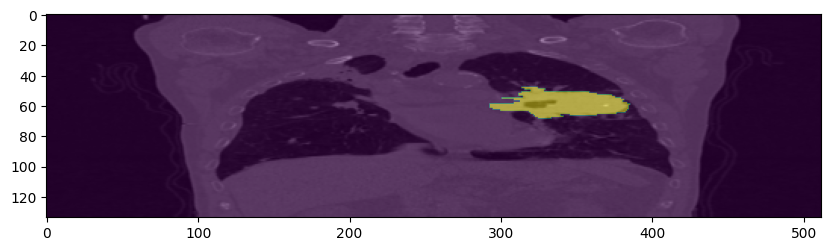

In [24]:
ct_slice = ct.get_fdata()[:,256,:].copy()
seg_slice = seg.get_fdata()[:,256,:].copy()

#rotate both 90 degrees counter clockwise
ct_slice = np.rot90(ct_slice)
seg_slice = np.rot90(seg_slice)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(ct_slice, cmap="gray")
ax.imshow(seg_slice, alpha=0.5)

# plot ct


# rotate plot 90 degrees counter clockwise using transfroms




plt.show()

